In [1]:
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [2]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [4]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [5]:
class MyNet(nn.Module):

    def __init__(self, w_layers, d):

        super().__init__()
        self.tcn = TemporalConvNet(w_layers[0], w_layers[1:], kernel_size=3, dropout=d)
   
    def forward(self, Ws):
        pred = self.tcn(Ws)
        return (torch.tanh(pred))


In [6]:
w_file = '../data/w_dm.npy'
y_file = '../data/y_dm.npy'

In [7]:
w = np.load(w_file)
ws = np.array([[[5e4,50,50,5,10,100]]])
w = w / ws
W = np.moveaxis(w, 1, 2)
wd = np.linspace(-0.9,2.1,300)[None,None]
wd = wd.repeat(len(W), 0)
W = np.concatenate([W, wd], 1)

In [8]:
y = np.load(y_file)[:,None]/2e4
yd = np.diff(y, 1, -1, prepend=0)
y = np.concatenate([y, yd], 1)

In [9]:
idx_max = y[:,0,-1].argmax()

In [10]:
pred_idx = np.arange(len(y))
val_idx = np.random.choice(pred_idx, size=300, replace=False)
train_idx = np.setdiff1d(pred_idx, val_idx)
print(train_idx.shape, val_idx.shape)

(2763,) (300,)


In [11]:
batch_size = 1000

pred_dataset = MyDataset(W, y, pred_idx)
train_dataset = MyDataset(W, y, train_idx)
val_dataset = MyDataset(W, y, val_idx)


pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))



3


In [12]:
d = 0.1
w_layers = [7, 8, 16, 32, 32, 16, 16, 16, 16, 2]

model = MyNet(w_layers, d)
model = model.to(device)

model_file_name = '../data/model_tcn.pth'        
# model.load_state_dict(torch.load(model_file_name, map_location=device))
sm = summary(model, data_inputs[0], print_summary=True,  max_depth=2)

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   TemporalBlock-1      [1000, 8, 300]             456             456
   TemporalBlock-2     [1000, 16, 300]           1,360           1,360
   TemporalBlock-3     [1000, 32, 300]           5,280           5,280
   TemporalBlock-4     [1000, 32, 300]           6,272           6,272
   TemporalBlock-5     [1000, 16, 300]           2,896           2,896
   TemporalBlock-6     [1000, 16, 300]           1,600           1,600
   TemporalBlock-7     [1000, 16, 300]           1,600           1,600
   TemporalBlock-8     [1000, 16, 300]           1,600           1,600
   TemporalBlock-9      [1000, 2, 300]             150             150
Total params: 21,214
Trainable params: 21,214
Non-trainable params: 0
-----------------------------------------------------------------------


In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()

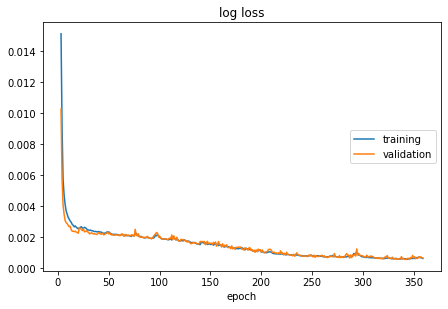

log loss:
training   (min:    0.001, max:    0.028, cur:    0.001)
validation (min:    0.001, max:    0.020, cur:    0.001)
[13:333] loss: 0.001 time:1.74


KeyboardInterrupt: 

In [21]:
for epoch in range(1000):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        Ws = Ws + 0.01 * torch.rand_like(Ws)
        outputs = model(Ws)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)
        
        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [22]:
model.load_state_dict(torch.load(model_file_name, map_location=device))
print('Model OK')

Model OK


In [23]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.07


0.903


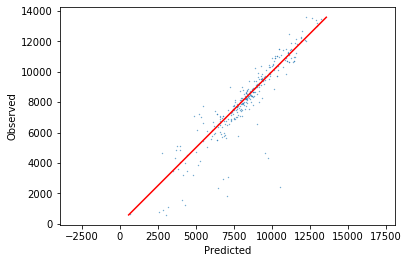

In [24]:
x = preds[:,0,-1].reshape(-1) * 2e4
y = obs[:,0,-1].reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


nan


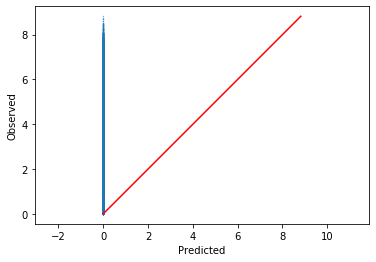

In [25]:
x = preds[:,1].reshape(-1) * 5e2
y = obs[:,1].reshape(-1) * 5e2

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

nan


/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


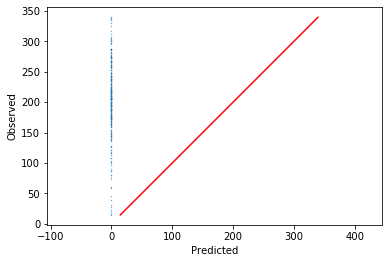

In [26]:
x = preds[:,1].sum(-1).reshape(-1) * 5e2
y = obs[:,1].sum(-1).reshape(-1) * 5e2

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

In [ ]:
ymax = pred_dataset[idx_max][1][None]
wmax = pred_dataset[idx_max][0][None]
wmax.requires_grad = True

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([wmax], lr=0.01)

In [ ]:
liveloss = PlotLosses()

In [ ]:
outputs = model(wmax)

In [ ]:
model.eval()
for i in trange(100):

    # Limpa os gradientes
    optimizer.zero_grad()

    # Obtem o output
#     wmaxx = F.dropout(wmax, 0.5)
    outputs = model(wmax)

    # Caulcula a perda pela loss function
#     loss = criterion(outputs[:,0], torch.cumsum(outputs[:,1], -1)) 
    loss =  -0.5 * outputs[0,1].sum() -0.5 * outputs[0,0,-1]
    
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()
    
    liveloss.update({
        'log loss': loss.item()
    })
liveloss.draw()

In [ ]:
pred = outputs.cpu().data.numpy()
ymax = ymax.cpu().data.numpy()

In [ ]:
plt.plot(pred[0,0])

In [ ]:
plt.plot(ymax[0,0])

In [ ]:
plt.plot(pred[0,1])

In [ ]:
plt.plot(np.cumsum(pred[0,1]))